# Trainable circuits

Up to now, we know circuits can behave like heuristic ML models and that we can compute (numerically) the derivatives with respect to an observable, so we can adapt and optimize those circuits given a target cost function.

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()

# sQUlearn

https://squlearn.github.io/user_guide/encoding_circuits.html

In [2]:
from squlearn import Executor

executor = Executor(execution="statevector_simulator")

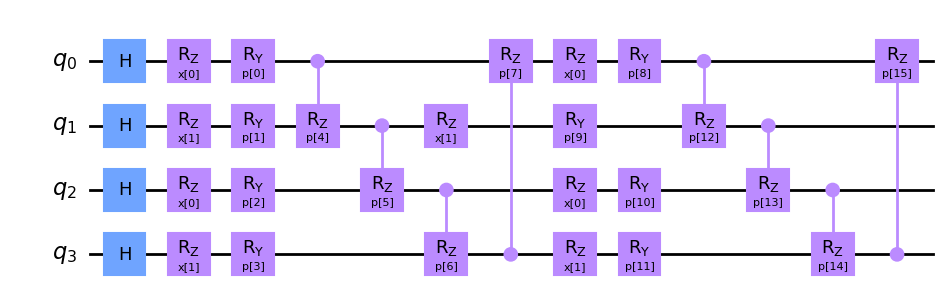

In [3]:
from squlearn.encoding_circuit import HubregtsenEncodingCircuit

pqc = HubregtsenEncodingCircuit(num_qubits=4, num_features=2, num_layers=2)
pqc.draw(output="mpl", style="clifford")

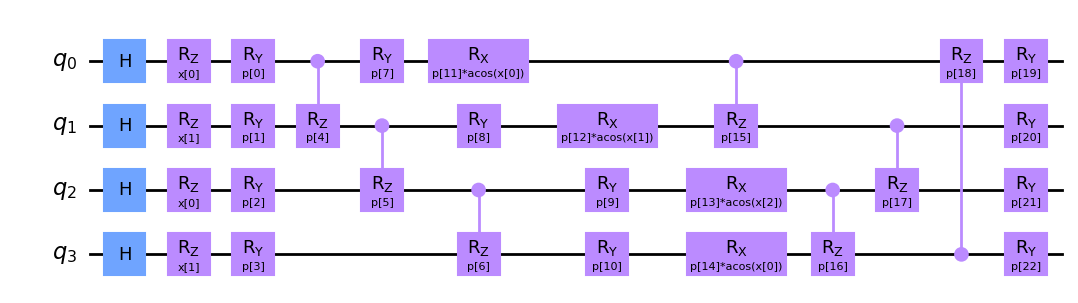

In [5]:
from squlearn.encoding_circuit import HubregtsenEncodingCircuit, ChebyshevPQC

fm1 = HubregtsenEncodingCircuit(num_qubits=4, num_features=2, num_layers=1, closed=False)
fm2 = ChebyshevPQC(num_qubits=4, num_features=3, num_layers=1)
# Combining both encoding circuits
fm3 = fm1 + fm2
fm3.draw(output="mpl", style="clifford")

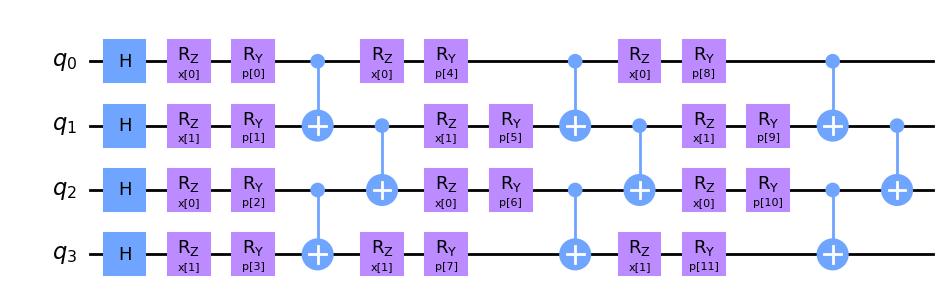

In [6]:
from squlearn.encoding_circuit import LayeredEncodingCircuit
from squlearn.encoding_circuit.layered_encoding_circuit import Layer

encoding_circuit = LayeredEncodingCircuit(num_qubits=4,num_features=2)
encoding_circuit.H()
layer = Layer(encoding_circuit)
layer.Rz("x")
layer.Ry("p")
layer.cx_entangling("NN")
encoding_circuit.add_layer(layer,num_layers=3)
encoding_circuit.draw(output="mpl", style="clifford")

https://squlearn.github.io/user_guide/kernel_methods.html#training-of-quantum-kernels

We can take our Iris data to see what the outcome of the trained kernels is.

In [7]:
import numpy as np

X_idx = np.where(iris.target < 2)
X = iris.data[X_idx]
Y = iris.target[X_idx]

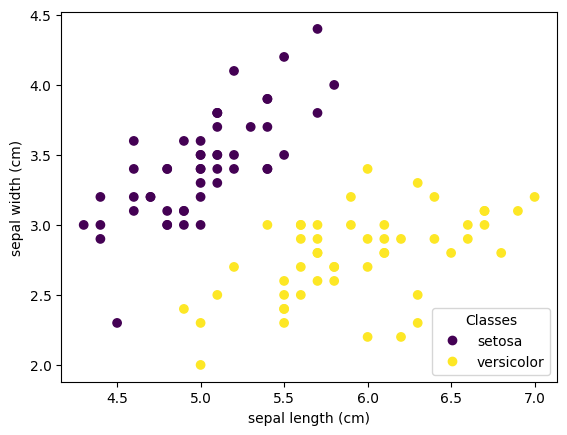

In [8]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=Y)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-0.9, 0.9))
X_scaled = scaler.fit_transform(X)

features = X_scaled.shape[1]

# All together

In [11]:
from squlearn.optimizers import Adam
from squlearn.kernel import FidelityKernel
from squlearn.kernel import KernelOptimizer
from squlearn.kernel.loss import TargetAlignment

enc_circ = ChebyshevPQC(num_qubits=features, num_features=features, num_layers=2)
k_instance = FidelityKernel(
    encoding_circuit=enc_circ,
    executor=executor,
    parameter_seed=0
)
# set up the optimizer
adam_opt = Adam(options={"maxiter":20, "lr": 0.1})
# define KTA loss function
kta_loss = TargetAlignment()
kta_optimizer = KernelOptimizer(quantum_kernel=k_instance, loss=kta_loss, optimizer=adam_opt)
opt_kta_result = kta_optimizer.run_optimization(X=X_scaled, y=Y)
# retrieve optimized parameters
opt_kta_params = opt_kta_result.x

In [12]:
kta_loss.compute(data=X_scaled, labels=Y, parameter_values=opt_kta_params)

-0.7022055701983853